### Load The Raw Data

In [1]:
import mne

subject_number = '396'

# load raw data
file_path = '/Users/oferbudin/NirsLabProject/NirsLabProject/data/raw_data/P396_overnightData.edf'
raw = mne.io.read_raw_edf(file_path)

# select channel
channel_name = 'REC1'
raw_channel = raw.pick_channels([channel_name])
raw_channel.load_data()

# resample data
if raw_channel.info['sfreq'] != 1000:
    raw_channel = raw_channel.resample(1000, verbose=True)
raw_channel = raw_channel.notch_filter(60, verbose=True)
raw_channel = raw_channel.filter(0.1, 499, verbose=True)

Extracting EDF parameters from /Users/oferbudin/NirsLabProject/NirsLabProject/data/raw_data/P396_overnightData.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 50400485  =      0.000 ... 25200.243 secs...
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 499.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 499.50 Hz)
- Filter length: 33001 samples (33.001 sec)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


### Run The Model

In [2]:
import os
import joblib
import pandas as pd
import antropy as ant
import numpy as np
import scipy.stats as sp_stats
from mne_features.feature_extraction import extract_features


model_path = '/Users/oferbudin/NirsLabProject/NirsLabProject/data/models/xgb_full_f17_s12_b_V3.pkl'
model, feature_names = joblib.load(model_path).values()

# features extraction
window_size = int(1000 / 4)  # 250 ms
epochs = []
chan_raw = raw_channel.copy().get_data().flatten()
# normalize channel
chan_norm = (chan_raw - chan_raw.mean()) / chan_raw.std()
# run on all 250ms epochs
for i in range(0, len(chan_norm) - window_size, window_size):
    epochs.append(chan_norm[i: i + window_size])

mobility, complexity = ant.hjorth_params(epochs, axis=1)
curr_feat = {
    'subj': np.full(len(epochs), subject_number),
    'epoch_id': np.arange(len(epochs)),
    'kurtosis': sp_stats.kurtosis(epochs, axis=1),
    'hjorth_mobility': mobility,
    'hjorth_complexity': complexity,
    'ptp_amp': np.ptp(epochs, axis=1),
    'samp_entropy': np.apply_along_axis(ant.sample_entropy, axis=1, arr=epochs)
}

selected_funcs = ['teager_kaiser_energy']
X_new = extract_features(np.array(epochs)[:, np.newaxis, :], 1000, selected_funcs,
                        return_as_df=True)
# rename columns
names = []
for name in X_new.columns:
    if type(name) is tuple:
        if name[1] == 'ch0':
            names.append(name[0])
        else:
            names.append(name[0] + '_' + name[1].replace('ch0_', ''))
    else:
        names.append(name)

X_new.columns = names

# Convert to dataframe
curr_feat = pd.DataFrame(curr_feat)
curr_feat = pd.concat([curr_feat, X_new], axis=1)

chan_feat = {
    'chan_name': channel_name,
    'chan_ptp': np.ptp(chan_norm),
    'chan_skew': sp_stats.skew(chan_norm),
    'chan_kurt': sp_stats.kurtosis(chan_norm),
}

for feat in chan_feat.keys():
    curr_feat[feat] = chan_feat[feat]

# save the epochs as column for debugging
curr_feat['epoch'] = epochs
x = pd.DataFrame()
features = pd.concat([x, curr_feat], axis=0)
features = np.nan_to_num(features[feature_names])

# predict using the model
predictions = model.predict_proba(features)
y = (predictions[:, 1] >= 0.8).astype(int)

spikes_onsets = np.where(y == 1)[0] / 4


[12:03:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1667849614592/work/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



### Spikes Features

In [3]:
from functools import partial
from scipy.signal import find_peaks


# utils functions

def get_spike_amplitude_and_length(data: np.ndarray, peak_index):
    # taking the spike range (SPIKE_RANGE_SECONDS) before and after the peak timestamp of the window
    spike_range_in_indexes = int(0.25 * 1000)
    start_frame_index = max(0, peak_index-spike_range_in_indexes)
    end_frame_index = min(len(data), peak_index+spike_range_in_indexes)

    amplitude = data[peak_index]
    baseline = np.mean(data[start_frame_index:peak_index])
    relative_amplitude = amplitude - baseline

    # finding the closest point before the peak with half of the peak amplitude
    first_half_start = start_frame_index + np.where(data[start_frame_index:peak_index] < amplitude / 2)[0]
    if len(first_half_start) > 0:
        first_half_start = first_half_start[-1]
    else:
        # if there is no point before the peak with half of the peak amplitude, we will take the start of the window
        return {'index': peak_index, 'amplitude': amplitude, 'length': -1}

    # finding the closest point after the peak with half of the peak amplitude
    second_half_end = peak_index + np.where(data[peak_index:end_frame_index] < amplitude / 2)[0]
    if len(second_half_end) > 0:
        second_half_end = second_half_end[0]
    else:
        # if there is no point after the peak with half of the peak amplitude, we will take the end of the window
        return {'index': peak_index, 'amplitude': amplitude, 'length': -1}

    return {
        'index': peak_index,
        'amplitude': amplitude,
        'length': second_half_end - first_half_start,
    }

def get_spike_amplitude_index(channel_data: np.ndarray, spike_window_timestamp: float) -> int:
    wide_spike_window_start_index = max(0, int((spike_window_timestamp-0.125) * 1000))
    _end = int((spike_window_timestamp + 0.25 + 0.125) * 1000)
    wide_spike_window_data = channel_data[wide_spike_window_start_index:_end]

    # Find the peak of the spike in the wide_spike_window_data with length smaller than MAX_SPIKE_LENGTH_MILLISECONDS
    peaks, _ = find_peaks(wide_spike_window_data)
    spikes = map(lambda p: get_spike_amplitude_and_length(wide_spike_window_data, p), peaks)

    filtered_spikes = list(
        filter(lambda x: x['length'] <= 100, spikes)
    )
    if not filtered_spikes:
        return -1

    # Find the spike with the highest amplitude
    peak = max(filtered_spikes, key=lambda x: x['amplitude'])
    if peak['amplitude'] < 3 or peak['length'] < 20:
        return -1

    # Return the spike index in the channel data
    return wide_spike_window_start_index + peak['index']

def get_spikes_peak_indexes_in_spikes_windows(channel_data: np.ndarray, spikes_windows: np.ndarray):
    spikes = spikes_windows.copy()
    spikes = spikes.reshape(-1, 1)
    if spikes.shape[0] == 0:
        return None
    # Get the spike index in the channel data for each spike in the spikes array
    spikes = np.vectorize(partial(get_spike_amplitude_index, channel_data))(spikes)
    # Removes epochs that have no spike with length that smaller than  MAX_SPIKE_LENGTH_MILLISECONDS
    spikes = spikes[spikes >= 0]
    spikes = np.unique(spikes).reshape(-1, 1)
    spikes = spikes.astype(int)
    return spikes

def extract_spikes_peaks_features(channel_data: np.ndarray, spikes: np.ndarray):
    spikes = np.unique(spikes).flatten()

    if spikes.shape[0] == 0:
        return np.array([]), np.array([])

    # Vectorized feature extraction using np.vectorize
    v_extract_features = np.vectorize(partial(get_spike_amplitude_and_length, channel_data))

    # Perform feature extraction on all indexes at once
    features_array = v_extract_features(spikes)
    peaks = np.array([d['amplitude'] for d in features_array])
    lengths = np.array([d['length'] for d in features_array])

    return peaks, lengths

# utils ending

channel_data = raw_channel.get_data()[0]
channel_data = sp_stats.zscore(channel_data)
channel_spikes_indexes = get_spikes_peak_indexes_in_spikes_windows(channel_data, spikes_onsets)
amplitudes, lengths = extract_spikes_peaks_features(channel_data, channel_spikes_indexes)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 2.048 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Not setting metadata
22 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Using data from preloaded Raw for 22 events and 2001 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Need more than one channel to make topography for eeg. Disabling interactivity.
Not setting metadata
22 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 2001 original time points ...
0 bad epochs dropped
Applying baseline correction (mo

/Users/oferbudin/miniforge3/envs/mne/lib/python3.9/site-packages/mne/time_frequency/spectrum.py:617: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.3)
/Users/oferbudin/miniforge3/envs/mne/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
/Users/oferbudin/miniforge3/envs/mne/lib/python3.9/site-packages/mne/time_frequency/spectrum.py:617: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.3)
/Users/oferbudin/miniforge3/envs/mne/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a no

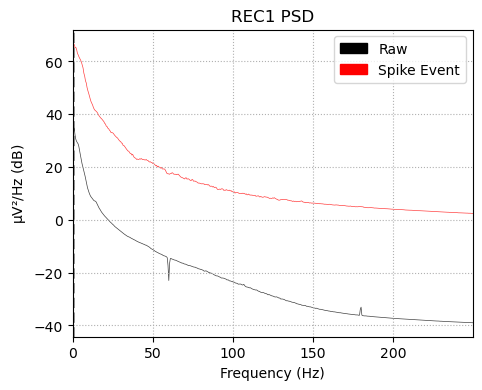

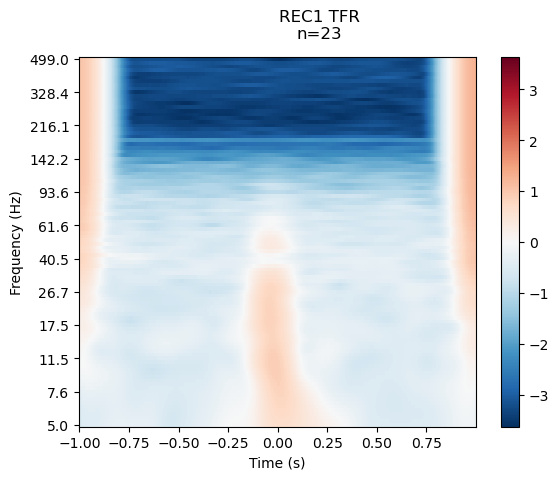

Not setting metadata
22 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 22 events and 2001 original time points ...
0 bad epochs dropped
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated


/var/folders/1m/l62lw4sj1msggc6lrf4hykdw0000gn/T/ipykernel_67053/861540317.py:67: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = epochs.plot_image(


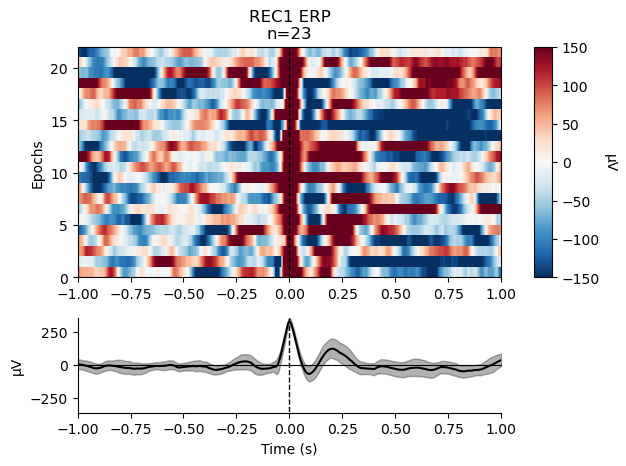

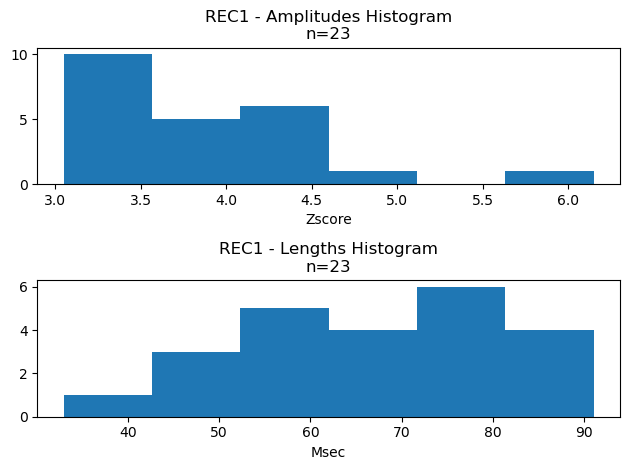

In [4]:
from mne.time_frequency import tfr_morlet
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

def create_epochs(raw_channel: mne.io.Raw, spikes: np.ndarray, tmin: int, tmax: int) -> mne.Epochs:
    # create epochs array shape as the expected format (n_epochs, 3) - [peak_timestamp, Not relevant,  Not relevant]
    zeros = np.zeros((spikes.shape[0], 2), dtype=int)
    spikes = np.hstack((spikes, zeros))
    indices = np.arange(spikes.shape[0]).reshape(-1, 1)
    spikes[:, -1] = indices[:, 0]
    spikes = spikes[spikes[:, 0] != spikes[0, 0]]
    return mne.Epochs(raw_channel, spikes, tmin=tmin, tmax=tmax)

def create_PSD_plot(raw_channel: mne.io.Raw, spikes_timestamps: np.ndarray):
    fig = plt.figure(layout='constrained')
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    # plot_psd is obsolete, but the new function plot_psd_topomap is not supporting fig saving
    raw_channel.plot_psd(
        fmin=0,
        fmax=250,
        picks=[raw_channel.ch_names[0]],
        ax=ax,
        show=True,
        spatial_colors=False
    )
    epochs = create_epochs(raw_channel, spikes_timestamps, -1, 1)
    epochs.plot_psd(
        fmin=0,
        fmax=250,
        ax=ax,
        show=True,
        spatial_colors=False,
        color='red'
    )
    ax.set_title(f'{raw_channel.ch_names[0]} PSD')
    ax.set_xlabel('Frequency (Hz)')
    legend = [
        mpatches.Patch(color='black', label='Raw'),
        mpatches.Patch(color='red', label='Spike Event')
    ]
    ax.legend(handles=legend, bbox_to_anchor=(1, 1))
    plt.tight_layout()

def create_TFR_plot(raw_channel: mne.io.Raw, spikes_timestamps: np.ndarray):
    epochs = create_epochs(raw_channel, spikes_timestamps, -1, 1)
    freqs = np.logspace(*np.log10([5, 499]), num=100)
    power, _ = tfr_morlet(
        inst=epochs,
        freqs=freqs,
        use_fft=True,
        return_itc=True,
        decim=3,
        n_jobs=1,
        n_cycles=freqs/2
    )
    power.plot(
        picks=[channel_name],
        show=True,
        mode='logratio',
        baseline=(-1, 1),
        title=f'{raw_channel.ch_names[0]} TFR\nn={len(spikes_timestamps)}'
    )

def create_ERP_plot(raw_channel: mne.io.Raw, spikes: np.ndarray):
    epochs = create_epochs(raw_channel, spikes, -1, 1)
    fig = epochs.plot_image(
        show=True,
        picks=[channel_name],
        vmin=-150,
        vmax=150,
        title=f'{raw_channel.ch_names[0]} ERP\nn={len(spikes)}'
    )[0]

def create_channel_features_histograms(amplitudes: np.ndarray, lengths: np.ndarray, channel_name: str):
    fig, ax = plt.subplots(2)
    ax[0].hist(amplitudes, bins='auto')
    ax[0].set_title(f'{channel_name} - Amplitudes Histogram\nn={len(amplitudes)}')
    ax[0].set_xlabel('Zscore')
    ax[1].hist(lengths, bins='auto')
    ax[1].set_title(f'{channel_name} - Lengths Histogram\nn={len(amplitudes)}')
    ax[1].set_xlabel('Msec')
    fig.tight_layout()
    plt.show()

create_PSD_plot(raw_channel, channel_spikes_indexes)
create_TFR_plot(raw_channel, channel_spikes_indexes)
create_ERP_plot(raw_channel, channel_spikes_indexes)
create_channel_features_histograms(amplitudes, lengths, channel_name)